In [1]:
from itertools import product
import numpy as np
from numpy.random import default_rng
rng = default_rng() # stuff for random sampling
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Toward a data query language #

## What's a Cube? A misnomer - it's four dimensional ##

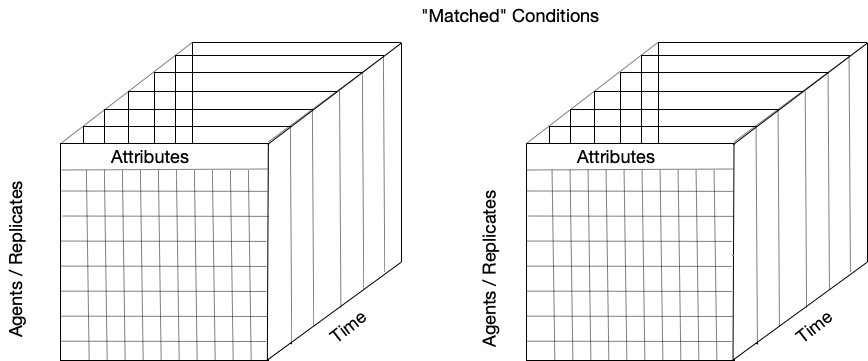

In [2]:
# cubex is our "example cube"

cubex = xr.open_dataset("cube.netcdf")
cubex

<xarray.Dataset>
Dimensions:       (scenarios: 4, replicates: 10000, times: 100)
Dimensions without coordinates: scenarios, replicates, times
Data variables:
    health        (scenarios, replicates, times) float64 ...
    location      (scenarios, replicates, times) float64 ...
    age           (scenarios, replicates, times) float64 ...
    sex           (scenarios, replicates, times) float64 ...
    beta          (scenarios, replicates, times) float64 ...
    gamma         (scenarios, replicates, times) float64 ...
    masked        (scenarios, replicates, times) float64 ...
    mask_mandate  (scenarios, replicates, times) float64 ...

In [23]:
from itertools import product
from scipy.stats import f_oneway, pearsonr, linregress, chisquare, describe,iqr

# we'll use cohort size as an example statistic in the following
def cohort_size (sample):
    ''' Returns a time series of the size of the cohort associated with a scope.'''
    any_var = list(sample.keys())[0]      # it doesn't matter which variable we look at
    return np.sum(sample[any_var],axis=0) 


## Specifying an Analysis ##

The elements of an analysis are:

- experimental scenarios

- cohorts

- variables

- time intervals

Once you've specified these things, you've implicitly defined a possibly large number of samples. For example, if you specify two experimental conditions and two cohorts, then implicitly you have specified four samples.  Denote these samples S00,S01,S10 and S11. These can be analyzed in many ways; for example:

- Correlations between the data in all six pairs of samples 

- Comparison between `mean(S00)` and `mean(S01)`
 
- Comparison between `mean(S00) - mean(S01)` and `mean(S10) - mean(S11)`

The `Analysis` class sets up all the samples that are implicit when we specify scenarios, cohorts and  time intervals.   Once this is done, specific analyses can be done between these samples. 


In [7]:
class Analysis ():
    def __init__(self, cube, scenarios, cohorts, variables, times,*args,**kwds):
        self.cube = cube
        self.scenarios = scenarios
        self.cohorts = cohorts
        self.variables = variables
        self.times = times
        self.scope = self.make_scope(*args,**kwds)
    
    def make_scope (self,*args,**kwds):
        
        # make tuples that index the combinations of cohorts, scenarios and intervals
        f = lambda x: np.arange(len(x))
        indices = product(f(self.cohorts),f(self.scenarios),f(self.times))
        
        ht,c = {}, self.cube[self.variables]
        
        # create the datasets for each combination
        for a, b in zip(product(self.cohorts,self.scenarios,self.times),indices):
            _cohort,_scenarios,_interval = a
            ht[b] = c.where(_cohort(c,*args,**kwds)).isel(scenarios = _scenarios,times = _interval)
            
        return ht
        

Here we define an analysis that involves two cohorts, two scenarios and two time intervals. Implicitly, this specifies eight samples of data.

In [ ]:
A = Analysis(
    cube = cubex,
    cohorts = [lambda cube: (cube.age.isin([0,1])) & (cube.sex==0) & (cube.health == 1),
               lambda cube: (cube.age.isin([2,3])) & (cube.sex==0) & (cube.health == 1)],
    scenarios = [0,1],
    variables = ['health','age','sex'],
    times = [np.arange(10,40),np.arange(40,80)]
)

These samples are stored in a dict.  For example, here is the sample from the first cohort, the second scenario and the first time interval:

In [19]:
A.scope[(0,1,0)] # first scenario, second cohort, first time interval

<xarray.Dataset>
Dimensions:  (replicates: 10000, times: 30)
Dimensions without coordinates: replicates, times
Data variables:
    health   (replicates, times) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0
    age      (replicates, times) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0
    sex      (replicates, times) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0

As another illustration, here are the cohort sizes over time in each of the eight samples:

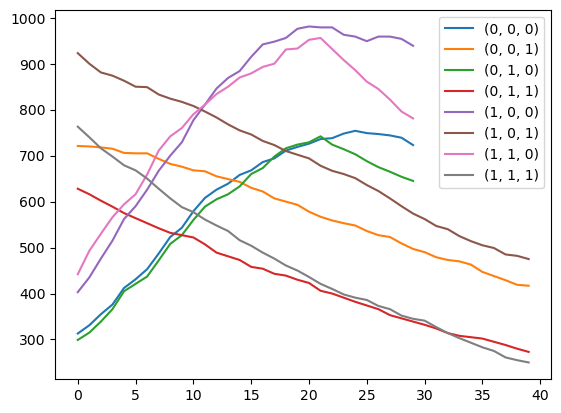

In [24]:
for sample in A.scope.values():
    plt.plot(cohort_size(sample))
plt.legend(A.scope.keys())

plt.show()

I don't love this way of specifying samples and in future I'll use xarray meta-data to make things easier for users.  But for now, a tuple (x,y,z) means "get me the sample associated with scenario x, cohort y and time interval z."

## Derived Variables ##

When you specify an analysis, as above, you say which Cube variables to include.  But what if you want to run an analysis not on the Cube variables but on variables *derived from* the Cube variables?  One example of a derived variable, show earlier, is `cohort_size`.  Given the raw Cube data we can build a boolean mask for each cohort, but this mask includes time as a dimension, and replicates drop in or out of cohorts dynamically.  So the `cohort_size` function builds a time series of the size of each cohort. 

We can pass functions for computing derived variables to the `Comparison` class, defined below. However, for the time being, each `Comparison` object can take only one such function.  I'm working on a more general approach.

## Comparisons ##

With this, we can write a simple class for making comparisons between samples.  This is a work in progress.  

In [ ]:
class Compare ():
    def __init__(self, samples, *args, derived_fn=None, **kwds):
        self.samples = samples if derived_fn is None else [derived_fn(s,*args,**kwds) for s in samples]
        self.args = args
        self.kwds = kwds
    
    def compare (self,*methods,**kwds):
        
        if 'describe' in methods:
            for sample in self.samples:
                nobs,minmax,mean,variance,_,_ = describe(sample)
                print(f'Number of observations: {nobs}')
                print(f'Min and Max: {minmax}')
                print(f'Mean, Median: {mean:.4f}, {np.median(sample):.4f}')
                print(f'Standard deviation, interquartile range: {variance**.5:.4f}, {iqr(sample):.4f}\n')
        
        if 'pearson' in methods: # Hack: Write code for full correlation matrix
            result = pearsonr(self.samples[0],self.samples[1])
            print(f'Pearson correlation coefficient: {result[0]:.4f}\n')
            
        if 'plot_series' in methods:
            for sample in self.samples:
                plt.plot(sample)
            
        if 'anova1d' in methods:
            print("\nOne-way analysis of variance:")
            f = f_oneway(*self.samples)
            print(f'F statistic: {f[0]:.4f},  p-value:  {f[1]:.4f}')
                

The following sets up a comparison between two samples from Analysis `A`, defined above.  The function `cohort_size` is passed in for the purpose of deriving a variable from the data in the samples. We ask for four analyses of these two samples:

- Simple descriptive statistics for each sample

- Plots of the time-series data in each sample

- The Pearson correlation coefficient between the points in the time series (NB: we assume these points are aligned but in general we'd need to align them before passing them to the correlation analysis.)

- A one-way analysis of variance, which doesn't make a whole lot of sense for time series data but if someone wanted to know about mean cohort size within an interval, this would be a way to do it. 

Number of observations: 30
Min and Max: (313.0, 754.0)
Mean, Median: 607.2000, 663.0000
Standard deviation, interquartile range: 146.4844, 237.5000

Number of observations: 30
Min and Max: (299.0, 742.0)
Mean, Median: 583.4000, 639.0000
Standard deviation, interquartile range: 139.2127, 214.5000

Pearson correlation coefficient: 0.9844


One-way analysis of variance:
F statistic: 0.4161,  p-value:  0.5214


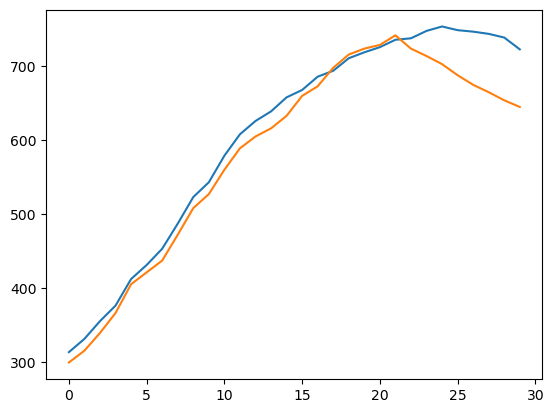

In [37]:
                
C = Compare([A.scope[(0,0,0)],A.scope[(0,1,0)]],derived_fn = cohort_size)

C.compare('describe','plot_series','pearson','anova1d')
        
    

The previous ANOVA shows no difference between mean cohort sizes in the two samples, which is hardly surprising given the plots, above.  However, suppose we compare two diffent experiment scenarios, as shown below.  In this case we compare scenarios 0 and 1, which are no mask mandate and mask mandate, respectively. In this case the mean sizes of the cohorts of infected people *are* significantly different.


One-way analysis of variance:
F statistic: 21.3076,  p-value:  0.0000


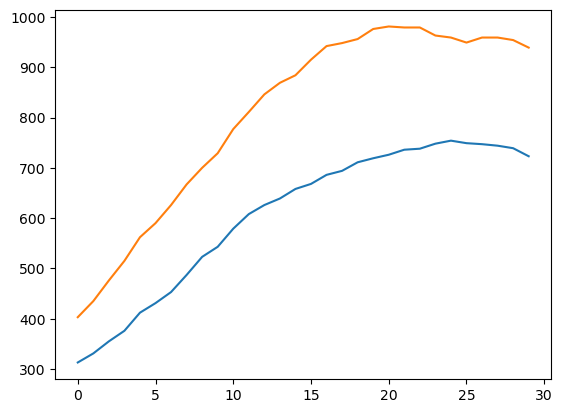

In [39]:
C = Compare([A.scope[(0,0,0)],A.scope[(1,0,0)]],derived_fn = cohort_size)
C.compare('anova1d','plot_series')

Here's an example for Adarsha.  The question he's looking at is "In a given time window, how long do infected people remain infected?" 

Suppose we want to analyze this question in two scenarios, for two different age groups, and for two time intervals. First we set up the analysis:

- `cohorts` specifies two cohorts: those in younger age categories (0 and 1) and those in older categories (2 and 3)

- `variables` specifies the variables we will be analyzing.  Obviously `age`, because we need it to extract the cohorts, and also `health` because it codes for health status.  0 means susceptible, 1 means infected, 2 means recovered.

- `conditions` codes for the experimental scenarios, we're looking at the first and second of these.

- `times` specifies two time intervals.

In [45]:
A = Analysis(
    cube = cubex,
    # young and old cohorts
    cohorts = [lambda cube: (cube.age.isin([0,1])),
               lambda cube: (cube.age.isin([2,3]))],
    # first two experimental conditions
    scenarios = [0,1],
    variables = ['health','age'],
    #times = [np.arange(10,40),np.arange(40,80)]
    times=[np.arange(100)]
)

Now we need to specify the statistic we're interested in.  Because health=1 means infected, we can simply count the number of 1's in the specified time interval for each replicate/agent. This is a derived variable for which we write a function. 

In [48]:
x=A.scope[(0,0,0)]

def duration_infected_in_interval (sample):
    x=sample.health.dropna(dim="replicates", how="any").to_numpy()
    return np.sum(x==1,axis=1)

duration_infected_in_interval(x)

array([ 5,  6, 79, ...,  0, 18,  0])

In [49]:
for k,sample in A.scope.items():
    # each sample is one combination of scenario, cohort and time interval
    x = duration_infected_in_interval(sample)
    print(f'The mean duration of infection in condition {k} is {np.mean(x):.4f}')

The mean duration of infection in condition (0, 0, 0) is 21.0124
The mean duration of infection in condition (0, 1, 0) is 16.4306
The mean duration of infection in condition (1, 0, 0) is 25.6028
The mean duration of infection in condition (1, 1, 0) is 19.4940
